<font size="6">Computational explanation of ELECTRE Tri-B</font>

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/cghiaus/ELECTRE_Tri/main?labpath=docs%2Fexplanation%2Felectre_tri-b_explained.ipynb)

ELECTRE Tri-B is a sorting method for multiple-criteria decision-making ([MCDM](https://en.m.wikipedia.org/wiki/Multiple-criteria_decision_analysis)) in which alternatives are assigned to categories. The categories are completely ordered and defined by base (or reference) profiles ([Figueira et al. 2005](https://doi.org/10.1007/0-387-23081-5_4)). Since the categories are ordered, ELECTRE Tri-B is also a ranking method. 

Note that ELECTRE Tri-B uses boundary profiles to define categories: each category is defined by a lower and upper limiting profile. ELECTRE Tri-C uses central (characteristic) reference actions to define categories: each category is represented by a single central reference action that typifies that category ([Bouyssou, Marchant 2015]( https://doi.org/10.1016/j.ejor.2014.09.057)).

In [1]:
"""
Append `src/` directory to `path`
"""
import sys
import os

notebook_dir = os.path.dirname(os.path.abspath('__file__'))
project_root = os.path.dirname(os.path.dirname(notebook_dir))

src_dir = os.path.join(project_root, 'src')
sys.path.append(src_dir)

In [2]:
import pandas as pd

import electre_tri as et

# Introduction

ELECTRE is a family of **outranking** methods. The relation **"$a$ outranks $b$"** (denoted as $a > b$, $a\, S\, b$, or $a \succ b$) means that there are sufficient arguments to support the claim that **alternative $a$ is at least as good as alternative $b$**, while there are no strong arguments against this claim.

## Assumptions

1. The set of categories to which the alternatives must be assigned to is completely ordered (from the worst to the best, from the lowest to the highest priority, from the  riskiest to the safest, etc.).
2. Each category is defined to receive alternatives (or actions), which are processed in the same way.
3. Each category is defined by two reference alternatives, which represent its lower and upper bounds, called boundary reference alternatives, boundary actions or base profiles. The lower base profile of a better category is also the upper base profile of the worse consecutive category.
4. Each alternative is characterized by a value for each criterion.

## Definitions
  
### Input data

- **Criteria** $c = \{c_k\}$ are the different factors or attributes used to evaluate the alternatives in the decision making process. The criteria can be maximised (e.g. efficiency, savings) or minimised (e.g. cost, environmental impact).

- **Alternatives** are the options or items being evaluated and sorted into categories. These represent the decision objects that need to be classified according to multiple criteria. The performance of each alternative $a_i$ across all criteria $c_k$ form the **performance matrix** $A = \{a_{i,k}\}$ with $i=0,\ldots,n-1$ and $k=0,\ldots,m-1$, where $i$ is the index of alternatives and $k$ is the index of criteria. In the case of a criterion $k$ with an increasing preference direction, the higher the evaluation of the alternative on this criterion, $a_{i,k}$, the better the alternative performs on this criterion. Conversely, for a criterion $k$ with a decreasing performance direction, the lower the evaluation of the alternative on this criterion $a_{i,k}$, the lower the performance of this alternative on this criterion. In order to unify the calculations and not to have to differentiate between the two cases described above, the performance values in the criteria with a decreasing preference direction will be multiplied by "-1". Thus, these criteria will also get an increasing performance direction. 

- **Base profiles** (boundary reference actions, boundary actions, or reference profiles) define the boundaries between the predefined ordered **categories**. The base profiles form a matrix: $B = \{b_{j,k}\}$ with $j=0,\ldots,l-1$ and $k=0,\ldots,m-1$, where $j$ is the index of base profile and $k$ is the index of criteria. The base profile values for criteria with a decreasing preference direction will be multiplied by "-1".

- **Thresholds** account for uncertainty and imprecision of alternatives and base profiles. Thresholds form a matrix  $T = \{t_{j,k}\}$, where $k$ is the index of the criteria and $j=\{q, p, v\}$ are the vectors:

    - *indifference* $q = \{q_k \}$ : The largest difference in performance on a criterion that a decision maker considers negligible.
    - *preference* $p = \{p_k\}$ : The smallest difference in performance on a criterion that is considered significant for a clear preference.
    - *veto* $v = \{v_k\}$ : A difference in performance so large that it can negate any outranking relationship indicated by other criteria; the relation $q_k \leq p_k \leq v_k$ holds for each criterion $k.$


- **Criteria weights** $w = \{w_k\}$  represent the relative importance of each criterion in the decision-making process.

- **Credibility threshold** $\lambda$ is a cutting level value that determines whether the outranking relation between an alternative and a base profile is considered valid or not. It is usually set within the range of 0.5 to 1 (typically 0.75).

### Concepts specific to ELECTRE problem solving
- **Partial concordances** $c(a, b)$ between profiles $a$ and $b$ for each criterion $c$ is the truth value (between 0 and 1) of the concordance (i.e. agreement) with the statement *a outranks b for criterion c* where "outranks" means "is at least as good as". The comparison is done between alternative $a_{i,k}$ and base profile $b_{j,k}$ for each criterion $c_k$. The result, $c_{(k,j),i}(a_{i,k},b_{j,k})$, has a double index  (criterion $k$, base profile $j$) and columns corresponding to alternatives $i.$

- **Global concordance** $C(a,b)$ between profiles $a$ and $b$ is the truth value (berween 0 and 1) of the statement *a outranks b globally, i.e. for all criteria*, where "outranks" means "is at least as good as". The global concordances are calculated by using the partial concordances and the weights. They are the normalized weighted sum of partial concordances $c_{(k,j),i}$ for each criterion.

- **Partial discordances** $d(a, b)$ between profiles $a$ and $b$ for each criterion $c$ is the truth value (between 0 and 1) of the discordance (i.e. disagreement) with the statement: *a outranks b for criterion c*, where "outranks" means "is at least as good as". The comparison is done between alternative $a_{i,k}$ and base profile $b_{j,k}$ for each criterion $c_k.$

- **Credibility index** $\sigma(a, b)$ represents how credible the assertion *a outranks b* is. It can be seen as a fuzzy relation of outranking. The credibility index $\sigma(a,b)$ corresponds to the global concordance index $C(a,b)$ weakened by partial discordances $d(a, b).$

- **Outranking relationships** $a_i$ `I` $b_j$, $a_i$ `>` $b_j$, $a_i$  `<` $b_j$ and $a_i$ `R` $b_j$ (for indiferrent, preferred, not preferred, and incomparable) are relations between alternatives $a$ and $b$ derived from the credibility indexes $\sigma(a, b)$ and $\sigma(b, a).$

- **Optimistic classification** is a procedure in which the level of base profiles is increased till the lowest base profile which is "preferred" to alternative (b > a) is found. The alternative is assigned to the category having this base as upper bound. If no base is "preferred", the alternative is assigned to the category above the highest base profile.

- **Pessimistic classification** is a procedure in which the level of base profiles is decreased till a base profile which is "not preferred" to alternative (b < a) is found. The alternative is assigned to the category having this base as lower bound. If no base is "not preferred", the alternative is assigned to the category below the lowest base profile.

### Results

- **Classification** means obtaining a matrix of _alternatives_ classified in _categories_ in which `1` means that the alternative belongs to the catagory.

- **Ranking** means indicating for each alternative the category to which it belongs.

- **Sorting** means indicating for each category the alternatives that belong to it.

# Problem statement for ELECTRE Tri MCDM

ELECTRE Tri is a multiple-criteria decision-making (MCDM) method designed to sort a set of alternatives into predefined ordered categories based on their performance across multiple criteria, considering both supporting and opposing arguments for each assignment decision. 

The problem it addresses can be stated as:

**Given:**
- A set of criteria $c = \{c_k\}$ with associated weights $w = \{w_k\}$.
- A matrix $A = \{a_{i,k}\}$ of performances of alternatives $a_i$ for each criterion $k$.
- A matrix $B = \{b_{j,k}\}$ of base profiles (or category boundaries) $b_j$ for each criterion $k$ that form a set of $l$ ordered categories $C$, where $l - 1$ is the number of base profiles.
- Preference $p = \{p_k\}$, indifference $q = \{q_k\}$, and veto $v = \{v_k\}$ threshold vectors for each criterion.
- A credibility threshold $\lambda$ for outranking.


**Do:**

Assign each alternative $a_i ∈ A$ to one of the predefined categories $C_j ∈ C$ based on its performance across all criteria $c_k$ by using optimistic and pessimistic classification, while considering:

1. The outranking relations between alternatives and base profiles.
2. The credibility of these outranking relations.
3. The concordance and discordance between alternatives and base profiles.
4. The possibility of indifference and/or incomparability between alternatives and base profiles.

**Features:**

The method provides a robust sorting procedure that can handle:
- Multiple conflicting criteria.
- Imprecise or uncertain information.
- Partial compensation between criteria.
- Preference, indifference, and veto thresholds.

# Problem inputs: example

The alternatives (A), base profiles (B), thersholds (T) matrices and the weights (w) vector can be gouped in a `.csv` data file.

In [3]:
data_file = '../../data/mous3docl99_3.csv'
pd.read_csv(data_file)

,type,profile,c1,c2,c3,c4,c5
0,A,a1,75,67,85,82,90
1,A,a2,28,35,70,90,95
2,A,a3,45,60,55,68,60
3,B,b1,50,48,55,55,60
4,B,b2,70,75,80,75,85
5,T,q,5,5,5,5,5
6,T,p,10,10,10,10,10
7,T,v,30,30,30,30,30
8,w,NaN,1,1,1,1,1


In [4]:
A, B, T, w = et.read_electre_tri_base(data_file)

In [5]:
print("Performance of alternatives")
A

Performance of alternatives


,c1,c2,c3,c4,c5
a1,75,67,85,82,90
a2,28,35,70,90,95
a3,45,60,55,68,60


In [6]:
print("Base profiles")
B

Base profiles


,c1,c2,c3,c4,c5
b1,50,48,55,55,60
b2,70,75,80,75,85


In [7]:
print("Thresholds")
T

Thresholds


,c1,c2,c3,c4,c5
q,5,5,5,5,5
p,10,10,10,10,10
v,30,30,30,30,30


In [8]:
print("Weights")
w.to_frame().T.rename(index={0: 'w'})

Weights


,c1,c2,c3,c4,c5
w,1,1,1,1,1


In [9]:
credibility_threshold = 0.7

# Problem statement: example

__Given:__
- A set of five criteria $c = \{c_k\}$ with associated weights $w = \{w_k\}$.
- A matrix $A = \{a_{i,k}\}$ of performances of three alternatives $a_i$ for each criterion $k$.
- A matrix $B = \{b_{j,k}\}$ of two base profiles (or category boundaries) $b_j$ for each criterion $k$ that form a set of 3 ordered categories $C$: __b1 >__; __(b1, b2)__; __b2 <__.
- Preference $p = \{p_k\}$, indifference $q = \{q_k\}$, and veto $v = \{v_k\}$ threshold vectors for each criterion.
- A credibility threshold $\lambda$ for outranking.

__Do:__

Assign each alternative $a_i ∈ A$ to one of the predefined categories $C$: 
- __b1 >__ : alternative does not outrank the lowest base profile, $b_1 ≻ a_i$;
- __(b1, b2)__: alternative is between __b1__ and __b2__, $b_1 ≺ a_i ≺ b_2$ ;
- __b2 <__ : alternative outranks the highest base profile, $b_2 ≺ a_i$;.

The results of sorting and/or ranking of the three alternatives into the three categories are shown bellow.

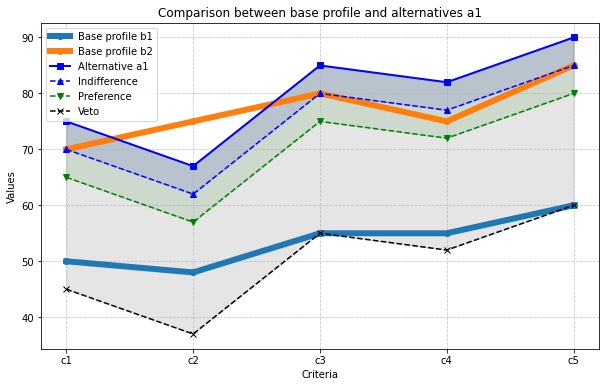

In [10]:
et.plot_base_profiles_vs_alternative(B, A.iloc[0], T)

Alternative __a1__:
- __b2 < a1__ in optimistic classification;
- __a1 ∈ (b1, b2)__ in pessimistic classification.

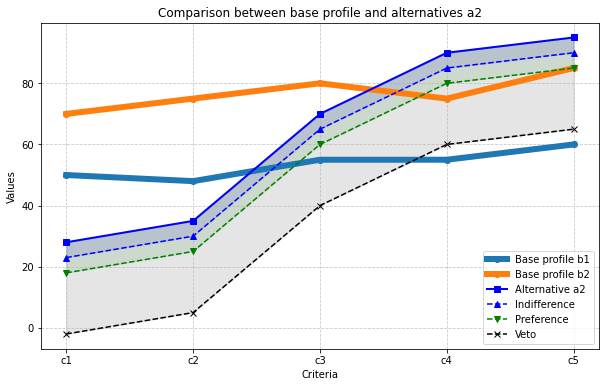

In [11]:
et.plot_base_profiles_vs_alternative(B, A.iloc[1], T)

Alternative __a2__:
- __b2 < a2__ in optimistic classification;
- __b1 > a2__ in pessimistic classification.

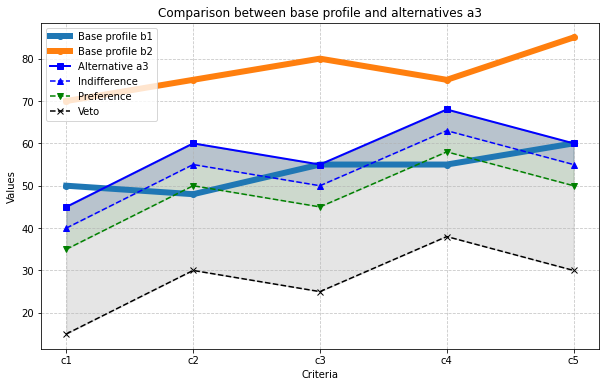

In [12]:
et.plot_base_profiles_vs_alternative(B, A.iloc[2], T)

Alternative __a3__:
- __a3 ∈ (b1, b2)__ in optimistic classification;
- __a3 ∈ (b1, b2)__ in pessimistic classification.

# Problem solving

Given:
- criteria to maximize<sup>*</sup>; 
- alternatives, __A__, and increasing base profiles, __B__;
- thresholds (preference, indifference, and veto), __T__;
- weights, __w__;
- credibility threshold, λ.

Calculate:
- partial concordance and discordance indexes;
- global concordance indexes;
- credibility indexes;
- outranking relations;

and perform classification using:
- optimistic (ascending) procedure;
- pessimistic (descending) procedure.

<sup>*</sup>_Note_: The sorting problem is solved for criteria to maximize. To deal with criteria that need to be minimized, multiply by $-1$ the data for these criteria, i.e. the columns of alternatives __A__ and base profiles __B__ (but not of theresholds __T__ and weights __w__) corresponding to these criteria.

## Partial concordance

Partial concordance between profiles $a$ and $b$ for each criterion $c$ is the truth value (between 0 and 1) of the concordance (i.e. agreement) with the statement:

$$a \text{ outranks } b \text{ for criterion } c$$

where "outranks" means "is at least as good as".

In ELECTRE Tri, two partial concordances are calculated for each criterion:

- `c_ab` between alternatives $a$ and base profiles $b$:
$$
c_{(k,j),i}(a_{i,k},b_{j,k}) = 
\begin{cases}
1 & \text{if } a_{i,k} \geq b_{j,k} - q_k\\
0 & \text{if } a_{i,k} < b_{j,k} - p_k\\
\frac{a_{i,k} - (b_{j,k} - p_k)}{p_k - q_k} & \text{otherwise}
\end{cases}
$$

- `c_ba` between base profiles $b$ and alternatives $a$:
$$
c_{(k,j),i}(b_{j,k}, a_{i,k}) = 
\begin{cases}
1 & \text{if } b_{j,k} \geq a_{i,k} - q_k\\
0 & \text{if } b_{j,k} < a_{i,k} - p_k\\
\frac{b_{j,k} - (a_{i,k} - p_k)}{p_k - q_k} & \text{otherwise}
\end{cases}
$$

where:
- $i$ is the index of alternatives in performance matrix $A$;
- $j$ - the index of base profiles in matrix $B$;
- $k$ - the column corresponding to criteria in matrixes $A$, $B$ and $T$.

Note that partial concordance is a MultiIndex DataFrame. The indexes are `criteria` and `base`. The columns are the alternatives.

In [13]:
c_ab, c_ba = et.partial_concordance(A, B, T)

### Partial concordance between alternatives and base profiles

For a given criterion $k$:
- If the alternative is higher than the base minus the indifference, then the concordance is 1, i.e. we agree that "$a$ outranks $b$" is true.

- If the alternative is lower than the base minus the preference, then the concordance is 0, i.e. we don't agree that "$a$ outranks $b$".

- Otherwise, the concordance is between 0 and 1, i.e. we partially agree that "$a$ outranks $b$".

In [14]:
print("\nPartial concordance \nc_ab = \n")
c_ab


Partial concordance 
c_ab = 



a1   a2   a3
criteria base               
c1       b1    1.0  0.0  1.0
         b2    1.0  0.0  0.0
c2       b1    1.0  0.0  1.0
         b2    0.4  0.0  0.0
c3       b1    1.0  1.0  1.0
         b2    1.0  0.0  0.0
c4       b1    1.0  1.0  1.0
         b2    1.0  1.0  0.6
c5       b1    1.0  1.0  1.0
         b2    1.0  1.0  0.0

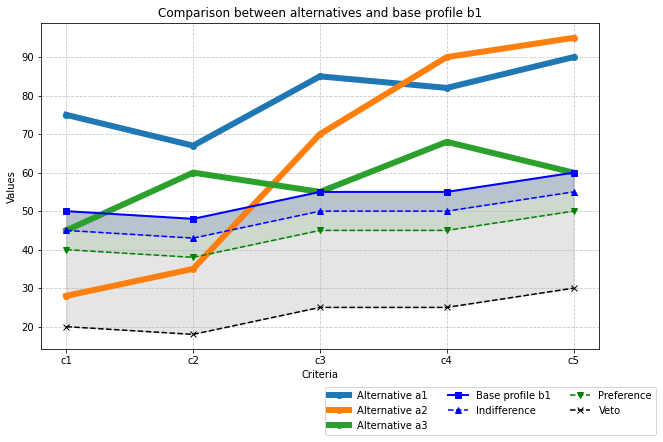


Partial concordance 
c(a, b1) = 



,,a1,a2,a3
criteria,base,,,
c1,b1,1.0,0.0,1.0
c2,b1,1.0,0.0,1.0
c3,b1,1.0,1.0,1.0
c4,b1,1.0,1.0,1.0
c5,b1,1.0,1.0,1.0


In [15]:
et.plot_alternatives_vs_base_profile(A, B.iloc[0], T)
print("\nPartial concordance \nc(a, b1) = \n")
c_ab.loc[(slice(None), 'b1'), :]

### Partial concordance between base profiles and alternatives

For a given criterion $k$:
- If the base  is higher than the alternative minus the indifference, then the concordance is 1, i.e. we agree that "$b$ outranks $a$" is true.

- If the base is lower than the alternative minus the preference, then the concordance is 0, i.e. we don't agree that "$b$ outranks $a$".

- Otherwise, the concordance is between 0 and 1, i.e. we partially agree that "$b$ outranks $a$".

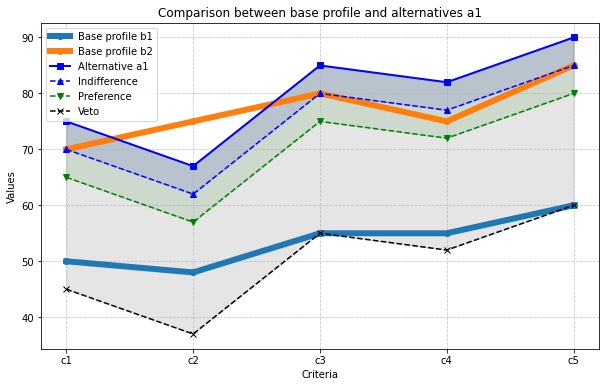


Partial concordance 
c(b, a1) = 



a1
criteria base     
c1       b1    0.0
         b2    1.0
c2       b1    0.0
         b2    1.0
c3       b1    0.0
         b2    1.0
c4       b1    0.0
         b2    0.6
c5       b1    0.0
         b2    1.0

In [16]:
et.plot_base_profiles_vs_alternative(B, A.loc['a1'], T)
print("\nPartial concordance \nc(b, a1) = \n")
c_ba['a1'].to_frame()

## Discordance

Partial discordance between profiles `a` and `b` for each criterion `c` is the truth value (between 0 and 1) of the discordance (i.e. disagreement) with the statement:

$$a \text{ outranks } b \text{ for criterion } c$$

where "outranks" means "is at least as good as".

In ELECTRE Tri, two discordances are calculated:

- `d_ab` between alternatives $a$ and base profiles $b$:
$$
d_{(k,j),i}(a_{i,k},b_{j,k}) = 
\begin{cases}
0 & \text{if } a_{i,k} \geq b_{j,k} - p_k\\
1 & \text{if } a_{i,k} < b_{j,k} - v_k\\
\frac{a_{i,k} - (b_{j,k} - p_k)}{p_k - v_k} & \text{otherwise}
\end{cases}
$$

- `d_ba` between base profiles $b$ and alternatives $a$:
$$
d_{(k,j),i}(b_{j,k}, a_{i,k}) = 
\begin{cases}
0 & \text{if } b_{j,k} \geq a_{i,k} - p_k\\
1 & \text{if } b_{j,k} < a_{i,k} - v_k\\
\frac{b_{j,k} - (a_{i,k} - p_k)}{p_k - v_k} & \text{otherwise}
\end{cases}
$$ 

where:
- $i$ is the index of alternatives in performance matrix $A$;
- $j$ - the index of base profiles in matrix $B$;
- $k$ - the column (corresponding to criteria) in matrixes $A$, $B$ and $T$.

Note that (partial) discordance is a MultiIndex DataFrame. The indexes are `criteria` and `base`. The columns are the alternatives.

In [17]:
d_ab, d_ba = et.discordance(A, B, T)
d_ab

a1    a2    a3
criteria base                
c1       b1     0  0.60  0.00
         b2     0  1.00  0.75
c2       b1     0  0.15  0.00
         b2     0  1.00  0.25
c3       b1     0  0.00  0.00
         b2     0  0.00  0.75
c4       b1     0  0.00  0.00
         b2     0  0.00  0.00
c5       b1     0  0.00  0.00
         b2     0  0.00  0.75

### Discordance between alternatives and base profiles

For a given criterion $k$,

- If the alternative is higher than the base minus the preference, then the discordance is 0, i.e. we do not disagree that "$a$ outranks $b$" is true.

- If the alternative is lower than the base minus the veto, then the concordance is 1, i.e. we disagree that "$a$ outranks $b$".

- Otherwise, the discordance is between 0 and 1, i.e. we partially disagree that "$a$ outranks $b$".

In [18]:
print("\nPartial discordance between alternatives and base profiles \nd_ab = \n")
d_ab


Partial discordance between alternatives and base profiles 
d_ab = 



a1    a2    a3
criteria base                
c1       b1     0  0.60  0.00
         b2     0  1.00  0.75
c2       b1     0  0.15  0.00
         b2     0  1.00  0.25
c3       b1     0  0.00  0.00
         b2     0  0.00  0.75
c4       b1     0  0.00  0.00
         b2     0  0.00  0.00
c5       b1     0  0.00  0.00
         b2     0  0.00  0.75

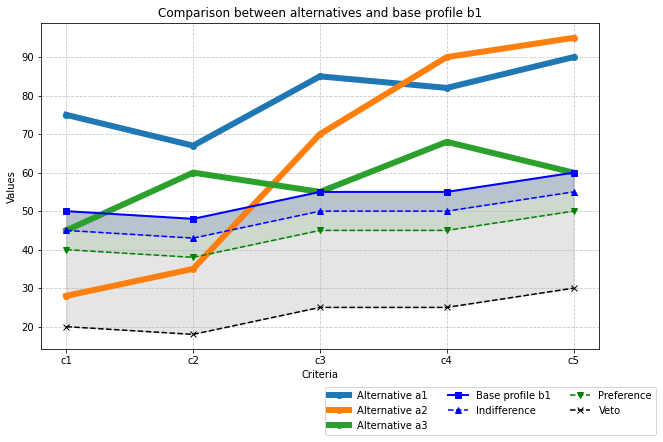


Partial discordance between alternatives and base profile b1
d(a, b1) = 



,,a1,a2,a3
criteria,base,,,
c1,b1,0,0.60,0.0
c2,b1,0,0.15,0.0
c3,b1,0,0.00,0.0
c4,b1,0,0.00,0.0
c5,b1,0,0.00,0.0


In [19]:
et.plot_alternatives_vs_base_profile(A, B.iloc[0], T)
print("\nPartial discordance between alternatives and base profile b1\nd(a, b1) = \n")
d_ab.loc[(slice(None), 'b1'), :]

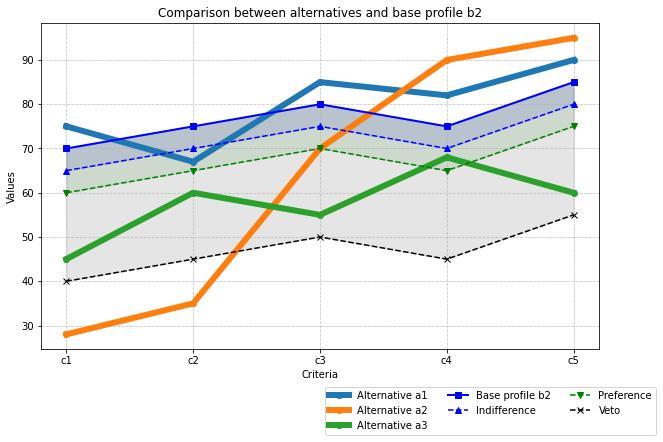


Partial discordance between alternatives and base profile b2 
d(a, b2) = 



,,a1,a2,a3
criteria,base,,,
c1,b2,0,1.0,0.75
c2,b2,0,1.0,0.25
c3,b2,0,0.0,0.75
c4,b2,0,0.0,0.00
c5,b2,0,0.0,0.75


In [20]:
et.plot_alternatives_vs_base_profile(A, B.loc['b2'], T)
print("\nPartial discordance between alternatives and base profile b2 \nd(a, b2) = \n")
d_ab.loc[(slice(None), 'b2'), :]

### Discordance between base profiles and alternatives

For a given criterion $k$,

- If the base is higher than the alternative minus the preference, then the discordance is 0, i.e. we do not disagree that "$b$ outranks $a$" is true.

- If the base is lower than the alternative minus the veto, then the concordance is 1, i.e. we disagree that "$b$ outranks $a$".

- Otherwise, the discordance is between 0 and 1, i.e. we partially disagree that "$b$ outranks $a$".

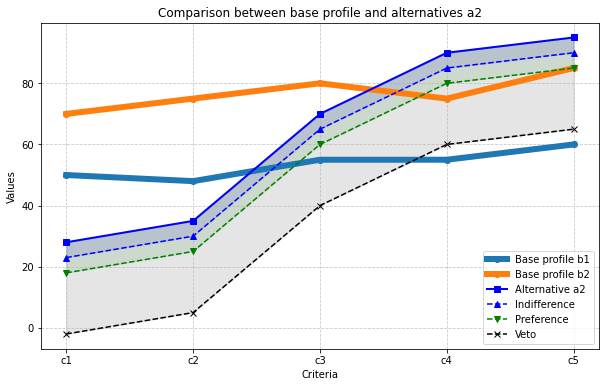


Partial discordance between base profiles and a2
d(b, a2) = 



a2
criteria base      
c1       b1    0.00
         b2    0.00
c2       b1    0.00
         b2    0.00
c3       b1    0.25
         b2    0.00
c4       b1    1.00
         b2    0.25
c5       b1    1.00
         b2    0.00

In [21]:
et.plot_base_profiles_vs_alternative(B, A.loc['a2'], T)
print("\nPartial discordance between base profiles and a2\nd(b, a2) = \n")
d_ba['a2'].to_frame()

## Global concordance

Global concordance between profiles $a$ and $b$ is the truth value (between 0 and 1) of the statement:
$$a \text{ outranks } b \text{ globally, i.e. for all criteria}$$
where "outranks" means "is at least as good as".

The global concordances are calculated by using the partial concordances and the weights. They are the normalized weighted sum of partial concordances $c_{(k,j),i}$ for each criterion.

The global concordance between alternatives $a_i$ and base profiles $b_j$ for criterion $k$ is:
$$
C_{j,i}(a_i,b_j) = \frac{\sum_k w_k · c_{(k,j),i}(a_{i,k},b_{j,k})}{\sum_k w_k}
$$

The global concordance between base profiles $b_j$ and alternatives $a_i$ for criterion $k$ is:

$$
C_{j,i}(b_j, a_i) = \frac{\sum_k w_k · c_{(k,j),i}(b_{j,k}, a_{i,k})}{\sum_k w_k}
$$

where:
- $i$ - index of alternatives in performance matrix $A$;
- $j$ - index of base profiles in matrix $B$;
- $k$ - column (corresponding to criteria) in matrixes $A$ and $B$;
- $w_k$ - weights of criteria;
- $c_{(k,j),i}(a_{i,k},b_{j,k})$ - partial concordance between alternatives $a_i$ and base profiles $b_j$ for criterion $k$;
- $c_{(k,j),i}(b_{j,k}, a_{i,k})$ - partial concordance between base profiles $b_j$ and alternatives $a_i$ for criterion $k$.

In [22]:
C_ab = et.global_concordance(c_ab, w)
C_ab

,a1,a2,a3
base,,,
b1,1,0.6,1
b2,0.88,0.4,0.12


In [23]:
C_ba = et.global_concordance(c_ba, w)
C_ba

,a1,a2,a3
base,,,
b1,0,0.4,0.6
b2,0.92,0.6,1


## Credibility index of outranking relation

Credibility index represents how credible the assertion "$a$ outranks $b$" is. It can be seen as a fuzzy relation of outranking. The credibility index $\sigma(a,b)$ corresponds to the global concordance index $C(a,b)$ weakened by discordances $d(a, b)$:

- When no criterion shows strong opposition (discordance) to the outranking relation, the credibility index is equal to the global concordance.

- When a discordant criterion opposes a veto to the assertion ”$a$ outranks $b$" (i.e. discordance is 1), then credibility index $\sigma(a,b)$ becomes null (the assertion ”$a$ outranks $b$" is not credible at all).

- When one or more criteria strongly oppose the outranking relation (i.e., their discordance exceeds the global concordance), the credibility index is reduced by multiplying the global concordance by a factor derived from the discordances that exceed the global concordance. The formula for this correction involves a product of terms, each representing the effect of a discordant criterion.

The credibility index that alternative $a_i$ outranks base profile $b_j$ is:

$$
\sigma_{j,i}(a_i,b_j) = C_{j,i}(a_i, b_j)\prod_{k \in K}\frac{1 - d_{(k,j),i}(a_{i,k},b_{j,k})}{1 - C_{j,i}(a_i,b_j)}
$$

with
$$
K = \left\{k \text{ so that } d_{(k,j),i}(a_{i,k},b_{j,k}) > C_{j,i}(a_i,b_j)\right\}
$$


and the credibility index that base profile $b_j$ outranks  alternative $a_i$ is:

$$
\sigma_{j,i}(b_j, a_i) = C_{j,i}(b_j, a_i)\prod_{k \in K}\frac{1 - d_{(k,j),i}(b_{j,k}, a_{i,k})}{1 - C_{j,i}(b_j, a_i)}
$$

with

$$
K = \left\{k \text{ so that } d_{(k,j),i}(b_{j,k}, a_{i,k}) > C_{j,i}(b_j, a_i)\right\}
$$

where:

- $i$ - index of alternatives in performance matrix $A$;
- $j$ - index of base profiles in matrix $B$;
- $k$ - column (corresponding to criteria) in matrices $A$ and $B$;
- $w_k$ - weights of criteria;
- $C_{j,i}(a_i, b_j)$ - global concordance between alternative $a_i$ and base profile $b_j$;
- $C_{j,i}(b_j, a_i)$ - global concordance between base profile $b_j$ and alternative $a_i$;
- $d_{(k,j),i}(a_{i,k},b_{j,k})$ - partial discordance between alternatives $a_i$ and base profiles $b_j$ for criterion $k$;
- $d_{(k,j),i}(b_{j,k}, a_{i,k})$ - partial discordance between base profiles $b_j$ and alternatives $a_i$ for criterion $k$;
- $K$ - sets of indexes of criteria for which the discordance is larger than the global concordance.


In [24]:
sigma_ab = et.credibility_index(C_ab, d_ab)
sigma_ab

,a1,a2,a3
base,,,
b1,1,0.6,1
b2,0.88,0,0.00234494


In [25]:
sigma_ba = et.credibility_index(C_ba, d_ba)
sigma_ba

,a1,a2,a3
base,,,
b1,0,0,0.6
b2,0.92,0.6,1


## Outranking relationships

The fuzzy outranking relations, expressed by the credibility indexes $\sigma$, is transformed into an outranking relationship  by using a cutting level $\lambda$.

There are four types of relationships that can be established between each $a_i$ and each $b_j$:

- $a_i$  `I`  $b_j$ : $a_i$  is indifferent to  $b_j$ if $\sigma(a_i, b_j) \geq \lambda$ and $\sigma(b_j, a_i) \geq \lambda$ 
- $a_i$  `>`  $b_j$ : $a_i$  is preferred to  $b_j$ if $\sigma(a_i, b_j) \geq \lambda$ and $\sigma(b_j, a_i) < \lambda$ 
- $a_i$  `<`  $b_j$ : $a_i$  is not preferred to  $b_j$ if $\sigma(a_i, b_j) < \lambda$ and $\sigma(b_j, a_i) \geq \lambda$ 
- $a_i$  `R`  $b_j$ : $a_i$  incomparable to $b_j$ if $\sigma(a_i, b_j) < \lambda$ and $\sigma(b_j, a_i) < \lambda$

|                    | $\sigma(a_i, b_j) \geq \lambda$ |$\sigma(a_i, b_j) < \lambda$|
| ---------------------------------|-------------------|----------------------------|
| $\sigma(b_j, a_i) \geq \lambda$  | $a_i$  `I`  $b_j$ | $a_i$  `<`  $b_j$ |
| $\sigma(b_j, a_i) < \lambda$     | $a_i$  `>`  $b_j$ | $a_i$  `R`  $b_j$ |


In [26]:
outranking = et.outrank(sigma_ab, sigma_ba, credibility_threshold=0.7)
outranking

,a1,a2,a3
base,,,
b1,≺,R,≺
b2,I,R,≻


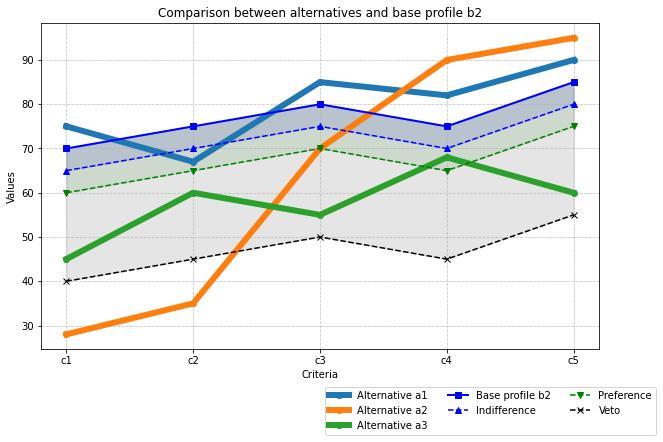

In [27]:
et.plot_alternatives_vs_base_profile(A, B.loc['b2'], T)

## Optimistic and pessimistic classification

Optimistic and pessimistic classification procedures are used to assign
alternatives to ordered categories separated by base profiles.
These procedures utilize outranking relations:
 - `>` : preferred
 - `<` : not preferred
 - `I` : indifferent
 - `R` : incomparable

between the alternatives and the base profiles.

- The **optimistic** procedure increases the level of base profiles till the lowest base profile which is "preferred" to alternative (b `>` a) is found. The alternative is assigned to the category having this base as upper bound. If no base is "preferred", the alternative is assigned to the category above the highest base profile.

- The **pessimistic** procedure decreases the level of base profiles till a base profile which is "not preferred" to alternative (b `<` a) is found. The alternative is assigned to the category having this base as lower bound. If no base is "not preferred", the alternative is assigned to the category below the lowest base profile

When the outranking relation between base and alternative is only of "preference" (b `>` a or b `<` a), the classification of the alternative gives the same result with optimistic and pessimistic procedure. For example, consider the outranking relation $b$ = ["<", "<", ">", ">", ">", ">"] for an alternative a. Both classifications (optimistic and pessimistic) classify alternative $a$ in $(b_1, b_2)$, i.e. $a ∈ (b_1, b_2)$.

When the outranking relation between alternative and base profile is "indifferent" (`I`) or "incomparable" (`R`), the pessimistic procedure assigns the alternative in a lower category than the optimistic procedure. For example, consider the outranking relation $b$ = ["<", "<", "I", "R", ">", ">"] for an alternative $a$:

- Optimistic classification starts from lowest base profile $b_0$ = "<" and increases the index of $b$ till $b_4$ = ">". The alternative is classified in $(b_3, b_4)$, i.e. $a ∈ (b_3, b_4).$

- Pessimistic classification starts from highest base profile $b_{-1}$ = ">" and decreases the index of $b$ till $b_1$ = "<". The alternative is classified in $(b_1, b_2)$, i.e. $a ∈ (b_1, b_2).$

In [28]:
optimistic, pessimistic = et.classify(outranking)

In [29]:
print("\nOptimistic classification")
optimistic


Optimistic classification


,a1,a2,a3
b1 ≻,NaN,NaN,NaN
"(b1, b2)",NaN,NaN,1.0
b2 ≺,1.0,1.0,NaN


In [30]:
print("\nPessimistic classification")
pessimistic


Pessimistic classification


,a1,a2,a3
b1 ≻,NaN,1.0,NaN
"(b1, b2)",1.0,NaN,1.0
b2 ≺,NaN,NaN,NaN


## Raking and sorting

The optimistic and pessimistic classifications can be:
- ranked, by indicating for each alternative the class to which it belongs;

- sorted, by indicating for each class the alternatives that belong to it.

In [31]:
pessi_rank = et.rank(pessimistic)
print('\nPessimistic ranking')
pessi_rank.to_frame()


Pessimistic ranking


,0
a1,"∈ (b1, b2)"
a2,∈ b1 ≻
a3,"∈ (b1, b2)"


In [32]:
pessi_sort = et.sort(pessimistic)
print('\nPessimistic sorting')
pessi_sort.to_frame()


Pessimistic sorting


,0
b1 ≻,[a2]
"(b1, b2)","[a1, a3]"
b2 ≺,[]


# Examples

ELECTRE Tri MCDM method is implemented in a function. Here are the results of some examples from literature.

## Simple example with base profiles

In [33]:
data_file = '../../data/base_profile.csv'
pd.read_csv(data_file)

,type,profile,c1,c2
0,A,a1,8.5,18.0
1,A,a2,14.0,16.0
2,A,a3,5.0,27.0
3,B,b1,10.0,15.0
4,B,b2,15.0,20.0
5,T,q,1.0,2.0
6,T,p,2.0,4.0
7,T,v,4.0,8.0
8,w,NaN,0.7,0.3


In [34]:
# Problem statement
data_file = '../../data/base_profile.csv'
credibility_threshold = 0.7

# Problem solving
A, B, T, w = et.read_electre_tri_base(data_file)
optimistic, pessimistic = et.electre_tri_b(A, B, T, w,
                                         credibility_threshold)

# Optimistic and pessimistic sorting
opti_sort = et.sort(optimistic)
print('\nOptimistic sorting \n')
opti_sort.to_frame(name="alternatives").rename_axis("categories")


Optimistic sorting 



,alternatives
categories,
b1 ≻,[a1]
"(b1, b2)",[]
b2 ≺,"[a2, a3]"


In [35]:
pessi_sort = et.sort(pessimistic)
print('Pessimistic sorting')
pessi_sort.to_frame(name="alternatives").rename_axis("categories")

Pessimistic sorting


,alternatives
categories,
b1 ≻,"[a1, a3]"
"(b1, b2)",[a2]
b2 ≺,[]


## Iskafi (2022)

Example from:

> Iskafi, K. (2022). Recherche opérationnelle. Mathématique pour aide à la décision.
Génie réseux et télécomunication. ENSA, Maroc
https://fr.scribd.com/document/627158131/R-O-Pr-Khalid-ISKAFI

Input data:

- performance matrix: Table 10.1, page 94
- base profiles: Table 10.13, page 101

Results:
- ELECTRE Tri optimistic and pessimistic sorting: Table 10.31, page 107

In [36]:
data_file = '../../data/isfaki_T10_1_T10_13.csv'
pd.read_csv(data_file)

,type,profile,c1,c2,c3,c4,c5
0,A,a1,0.72,3.56,1.34,0.62,44.34
1,A,a2,0.80,3.94,1.43,0.74,36.36
2,A,a3,0.76,3.63,1.38,0.89,48.75
3,A,a4,0.78,3.74,1.45,0.72,42.13
4,A,a5,0.74,3.54,1.37,0.73,36.99
5,A,a6,0.69,3.74,1.45,0.84,42.43
6,A,a7,0.70,3.28,1.28,0.83,47.43
7,A,a8,0.86,3.37,1.15,0.80,80.79
8,B,M,0.75,3.50,1.30,0.73,42.00
9,B,B,0.80,3.70,1.37,0.79,43.00


In [37]:
# Problem solving
A, B, T, w = et.read_electre_tri_base(data_file)
optimistic, pessimistic = et.electre_tri_b(A, B, T, w,
                                           credibility_threshold)

# Optimistic and pessimistic sorting
opti_sort = et.sort(optimistic)
print('Optimistic sorting')
opti_sort.to_frame(name="alternatives").rename_axis("categories")

Optimistic sorting


,alternatives
categories,
M ≻,[a7]
"(M, B)","[a1, a3, a5]"
B ≺,"[a2, a4, a6, a8]"


In [38]:
pessi_sort = et.sort(pessimistic)
print('Pessimistic sorting')
pessi_sort.to_frame(name="alternatives").rename_axis("categories")

Pessimistic sorting


,alternatives
categories,
M ≻,"[a1, a5, a7, a8]"
"(M, B)","[a3, a4, a6]"
B ≺,[a2]


## Mousseau et al. (1999): dichotomy

Example from:

> Mousseau, V., Slowinski, R., & Zielniewicz, P. (1999). ELECTRE TRI 2.0
Methodological guide and user’s manual. Universite Paris Dauphine,
Document du LAMSADE, 111, 263-275.
https://www.lamsade.dauphine.fr/mcda/biblio/PDF/mous3docl99.pdf

Input data:

- performance matrix: Table 1, page 15
- thresholds and weights: Table 2, page 16
- base profile: 1st paragraph, page 16

This example has a single base profile and two categories: worse than base profile, "b >" and better than base profile, "b <".

In [39]:
data_file = '../../data/mous3docl99_2.csv'
pd.read_csv(data_file)

,type,profile,c1,c2,c3,c4,c5
0,A,a1,75,67,85,82,90
1,A,a2,28,35,70,90,95
2,A,a3,45,60,55,68,60
3,B,b,70,75,80,75,85
4,T,q,5,5,5,5,5
5,T,p,10,10,10,10,10
6,T,v,30,30,30,30,30
7,w,NaN,1,1,1,1,1


In [40]:
# Problem solving
A, B, T, w = et.read_electre_tri_base(data_file)
optimistic, pessimistic = et.electre_tri_b(A, B, T, w,
                                           credibility_threshold)

In [41]:
# Optimistic sorting
opti_sort = et.sort(optimistic)
print('Optimistic sorting')
opti_sort.to_frame(name="alternatives").rename_axis("categories")

Optimistic sorting


,alternatives
categories,
b ≻,[a3]
b ≺,"[a1, a2]"


In [42]:
# Pessimistic sorting
pessi_sort = et.sort(pessimistic)
print('Pessimistic sorting')
pessi_sort.to_frame(name="alternatives").rename_axis("categories")

Pessimistic sorting


,alternatives
categories,
b ≻,"[a1, a2, a3]"
b ≺,[]


## Mousseau et al. (1999): trichotomy

Example from:

> Mousseau, V., Slowinski, R., & Zielniewicz, P. (1999). ELECTRE TRI 2.0
Methodological guide and user’s manual. Universite Paris Dauphine,
Document du LAMSADE, 111, 263-275.
https://www.lamsade.dauphine.fr/mcda/biblio/PDF/mous3docl99.pdf

Input data:

- performance matrix: Table 1, page 15
- thresholds and weights: Table 2, page 16
- base profile: Table 9, page 19

Results
- ELECTRE Tri optimistic and pessimistic sorting: page 20.

This example has two base profiles, "b1" and "b2" and three categories: 
- "b1 >" worse than base profile;
- "(b1, b2)" between b1 and b2,
- "b2 <" better than base profile.

In [43]:
data_file = '../../data/mous3docl99_3.csv'
pd.read_csv(data_file)

,type,profile,c1,c2,c3,c4,c5
0,A,a1,75,67,85,82,90
1,A,a2,28,35,70,90,95
2,A,a3,45,60,55,68,60
3,B,b1,50,48,55,55,60
4,B,b2,70,75,80,75,85
5,T,q,5,5,5,5,5
6,T,p,10,10,10,10,10
7,T,v,30,30,30,30,30
8,w,NaN,1,1,1,1,1


In [44]:
# Problem solving
A, B, T, w = et.read_electre_tri_base(data_file)
optimistic, pessimistic = et.electre_tri_b(A, B, T, w,
                                           credibility_threshold)

In [45]:
# Optimistic sorting
opti_sort = et.sort(optimistic)
print('\nOptimistic sorting:')
opti_sort.to_frame(name="alternatives").rename_axis("categories")


Optimistic sorting:


,alternatives
categories,
b1 ≻,[]
"(b1, b2)",[a3]
b2 ≺,"[a1, a2]"


In [46]:
# Pessimistic sorting
pessi_sort = et.sort(pessimistic)
print('\nPessimistic sorting:')
pessi_sort.to_frame(name="alternatives").rename_axis("categories")


Pessimistic sorting:


,alternatives
categories,
b1 ≻,[a2]
"(b1, b2)","[a1, a3]"
b2 ≺,[]


# References

Almeida-Dias, J., Figueira, J. R., & Roy, B. (2010). Electre Tri-C: A multiple
criteria sorting method based on characteristic reference actions.
European Journal of Operational Research, 204(3), 565-580.
https://doi.org/10.1016/j.ejor.2009.10.018, 
https://hal.science/hal-00907583v1/document

Almeida-Dias, J., Figueira, J. R., Roy, B.( 2010) A multiple criteria sorting
method defining each category by several characteristic reference actions:
The Electre Tri-nC method, Cahier du LAMSADE 294, Université Paris Daufine,
CNRS
https://hal.science/hal-01511223/document

Baseer, M., Ghiaus, C., Viala, R., Gauthier, N., & Daniel, S. (2023).
pELECTRE-Tri: Probabilistic ELECTRE-Tri Method—Application for the
Energy Renovation of Buildings. Energies, 16(14), 5296.
https://doi.org/10.3390/en16145296

Bouyssou, D., & Marchant, T. (2015). On the relations between ELECTRE TRI-B and ELECTRE TRI-C and on a new variant of ELECTRE TRI-B. European Journal of Operational Research, 242(1), 201-211. 
https://doi.org/10.1016/j.ejor.2014.09.057
https://hal.science/hal-01325794/document

Corrente, S., Greco, S., & Słowiński, R. (2016). Multiple criteria hierarchy
process for ELECTRE Tri methods. European Journal of Operational Research,
252(1), 191-203.
https://doi.org/10.1016/j.ejor.2015.12.053
https://pure.port.ac.uk/ws/portalfiles/portal/5001301/GRECO_Multiple_Criteria_Hierarchy_Process_for_ELECTRE_Tri_methods_Postprint.pdf

Daniel, S., & Ghiaus, C. (2023). Multi-Criteria Decision Analysis for Energy Retrofit of Residential Buildings: Methodology and Feedback from Real Application. Energies, 16(2), 902.
https://doi.org/10.3390/en16020902

Daniel, S., Ghiaus, C. (2023). ELECTRE Tri-B MCDA : an object oriented multi-criteria decision analysis tool in Python (2.0.0). Zenodo. https://doi.org/10.5281/zenodo.6394320

Daniel, S. (2023) Optimisation énergétique dans la rénovation du bâtiment. Architecture, aménagement de l'espace. PhD thesis, INSA de Lyon, 2023. Français. ⟨NNT : 2023ISAL0112⟩. ⟨tel-04689679⟩
https://theses.insa-lyon.fr/publication/2023ISAL0112/these.pdf

Figueira, J., Mousseau, V., Roy, B. (2005). Electre Methods. In: Multiple Criteria Decision Analysis: State of the Art Surveys. International Series in Operations Research & Management Science, vol 78. Springer, New York, NY. https://doi.org/10.1007/0-387-23081-5_4

Figueira, J. R., Mousseau, V., & Roy, B. (2016). ELECTRE methods. Multiple criteria decision analysis: State of the art surveys, 155-185.
https://www.lamsade.dauphine.fr/mcda/biblio/PDF/JFVMBR2005.pdf

Iskafi, K. (2022). Recherche opérationnelle. Mathématique pour aide à la décision.
Génie réseux et télécomunication. ENSA, Maroc
https://fr.scribd.com/document/627158131/R-O-Pr-Khalid-ISKAFI

Montenegro de Barros, G. M., Pereira, V., & Roboredo, M. C. (2021). ELECTRE tree: a machine learning approach to infer ELECTRE Tri-B parameters. Data Technologies and Applications, 55(4), 586-608.
https://doi.org/10.1108/DTA-10-2020-0256,
https://github.com/Valdecy/ELECTRE-Tree/blob/master/README.md

Mousseau, V., Slowinski, R., & Zielniewicz, P. (1999). ELECTRE TRI 2.0 Methodological guide and user’s manual. Universite Paris Dauphine,
Document du LAMSADE, 111, 263-275.
https://www.lamsade.dauphine.fr/mcda/biblio/PDF/mous3docl99.pdf

Mousseau, V., Slowinski, R., & Zielniewicz, P. (2000). A user-oriented
implementation of the ELECTRE-TRI method integrating preference elicitation
support. Computers & operations research, 27(7-8), 757-777.
https://doi.org/10.1016/S0305-0548(99)00117-3
https://www.lamsade.dauphine.fr/mcda/biblio/PDF/mous3cor00.pdf
